# Providing data-driven suggestions for HR with KMeans

Explore building a K-means model and analyzing the clusters. 

### Import packages

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from kneed import KneeLocator


### Load the Data

We load in the data.

Note, EDA has been performed on this data. Therefore we will proceed with feature selection and model construction

In [8]:
df0 = pd.read_csv("../data/cleaned_hr_dataset.csv")

In [9]:
df0.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [10]:
df0.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_monthly_hours      int64
tenure                     int64
work_accident              int64
left                       int64
promotion_last_5years      int64
department                object
salary                    object
dtype: object

### Data Preparation and Features Selections

From the output we observe the following:

* `department` is a categorical feature, which means it must be dummied for modelling.

* `salary` is categorical but it's ordinal i.e. the categories have a natural order. In this case, low, medium and high. Better not to dummy this column but rather to convert the levels to numbers 0-2.




In [11]:
# Make a copy of the data
df_enc = df0.copy()

# Encode the Salary variable as an ordinal numeric category
ordinal_mapping = {"low": 0,"medium": 1, "high": 2}
df_enc["salary"] = df_enc["salary"].map(ordinal_mapping)

# Dummy encode the `department` column
df_enc = pd.get_dummies(df_enc, drop_first=False)
df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


#### Feature Selection

In a previous iteration of modeling for this data using Decision trees and Random forest, we droped the following columns `satisfaction_level` and `average_monthly_hours` on the suspicion of data leakage. For this round of modeling I will drop an additional feature `last_evaluation` for the same reason (data leakage). The reason for this is, in production the last evaluation data for an employee may not be avialable either because it has been been conducting or too much time as passed since the last evaluation.

Additionally, i will engineer a new feature `overworked` just like the previous roud

In [20]:
# Create `overworked` column.
df2 = df_enc.copy()
df2["overworked"] = df2["average_monthly_hours"]

# Inspect max and min average monthy hours values
print(f"Max hours : {df2['overworked'].max()}")
print(f"Min hours : {df2['overworked'].min()}")

Max hours : 310
Min hours : 96


In [21]:
# Define `overworked` as working > 200 hrs/month
df2["overworked"] = (df2["overworked"] > 200).astype(int)

df2["overworked"].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int64

Drop the columns the following features 

- `satisfaction_level` 
- `average_monthly_hours` 
- `last_evaluation`

In [23]:
# Drop the `average_monthly_hours`
df2 = df2.drop(columns=["average_monthly_hours", "satisfaction_level", "last_evaluation"], axis=1)

# Display first few rows for resulting dataframe
df2.head()

,number_project,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,5,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
2,7,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
3,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
4,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [24]:
# Isolate the Outcome variable
y = df2["left"]
X = df2.drop("left", axis=1)

#### Feature Scaling
Because K-means uses distance between observations as the measure of similarity, it's important to scale data before modeling. The features aren’t in the optimal format for the KMeans class, so we'll need to build a preprocessing pipeline.

In [76]:
X_scaled = StandardScaler().fit_transform(X)

Now fit K-means and evaluate inertia for different values of k. Because we may not know how many clusters exist in the data, we begin by fitting K-means and examining the inertia values for different values of k.

To do this, write a function called `kmeans_inertia` that takes in `num_clusters` and `X_scaled` and returns a list of each k-value inertias.

In [77]:
# Fit K-means and evalaute inertia for different values of k.

# Assign a number from 2 to 25
num_clusters = [i for i in range(2,25)]

def kmeans_inertia(num_clusters:list[int], x_vals: np.array)-> list[int]:
    """
    Accepts as argument, list of ints and data array.
    Fits a KMeans model where k = each value in the list of ints.
    Returns each k-value's inertia appened to a list
    """
    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, n_init=20, random_state=42)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)
    return inertia

I have used the n_init argument to run the K-means with 20 initial cluster assignments (the default is 10). It is strongly recommend always running K-means clustering with a large value of n_init, such as 20 or 50, since otherwise an undesirable local optimum may be obtained.

In [78]:
# Return a list of inertia from k=2,tp k=10
inertias = kmeans_inertia(num_clusters, X_scaled)

# Take a look at first few inertia
inertias[:5]

[176200.95136761278,
 161834.64552451615,
 148054.1776144587,
 135297.5587917159,
 122580.29986913524]

Next, using seaborn plot inertia as a function of num_clusters. Where inertia is the sum of squared error (sse).

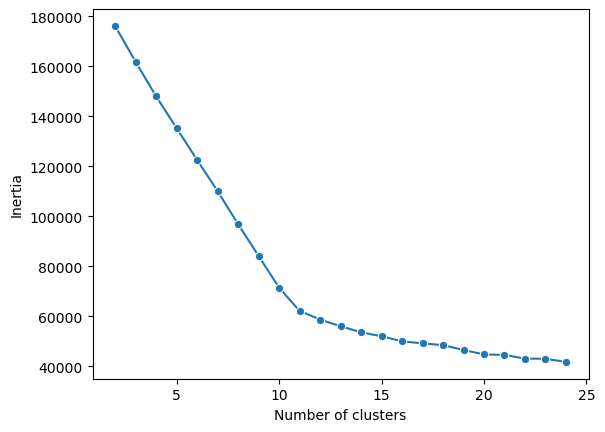

In [79]:
plot = sns.lineplot(x=num_clusters, y=inertias, marker="o")
plot.set_xlabel("Number of clusters")
plot.set_ylabel("Inertia");

In this plot, the elbow is located at x=11. Determining the elbow point in the inertia curve isn’t always straightforward. In instances where it difficult to choose the elbow point, Python package like [kneed](https://github.com/arvkevi/kneed), can be helpful to identify the elbow point programmatically:


In [80]:
from kneed import KneeLocator
kl = KneeLocator(
    range(2, 25), inertias, curve="convex", direction="decreasing"
)

n_clusters = kl.elbow
n_clusters

11

#### Pipeline

The next code block uses the concept of [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html#pipeline). The scikit-learn Pipeline class is a concrete implementation of the abstract idea of a machine learning pipeline.

The first step in pipeline will to implement the [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to perform dimensionality reduction

In [81]:
preprocessor = Pipeline(
    [
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

Now that we’ve built a pipeline to process the data, we’ll build a separate pipeline to perform k-means clustering. We’ll override the following default arguments of the KMeans class:

In [82]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)

The Pipeline class can be chained to form a larger pipeline. Build an end-to-end k-means clustering pipeline by passing the "preprocessor" and "clusterer" pipelines to Pipeline:

In [83]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

Calling ``.fit()`` with data as the argument performs all the pipeline steps on the data:

In [84]:
pipe.fit(X_scaled)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=11, n_init=50,
                                         random_state=42))]))])

In [90]:
labels = pipe["clusterer"]["kmeans"].labels_

# check how many of the samples were correctly labeled
correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))

Result: 975 out of 11991 samples were correctly labeled.


Evaluate the performance by calculating the silhouette coefficient:

In [89]:
pipe["clusterer"]["kmeans"].inertia_

2089.9038927073607

In [85]:
preprocessed_data = pipe["preprocessor"].transform(X_scaled)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)

0.4443873788240194

Since you specified n_components=2 in the PCA step of the k-means clustering pipeline, let'salso visualize the data in the context of the true labels and predicted labels. 

Plot the results using a pandas DataFrame and the seaborn plotting library:

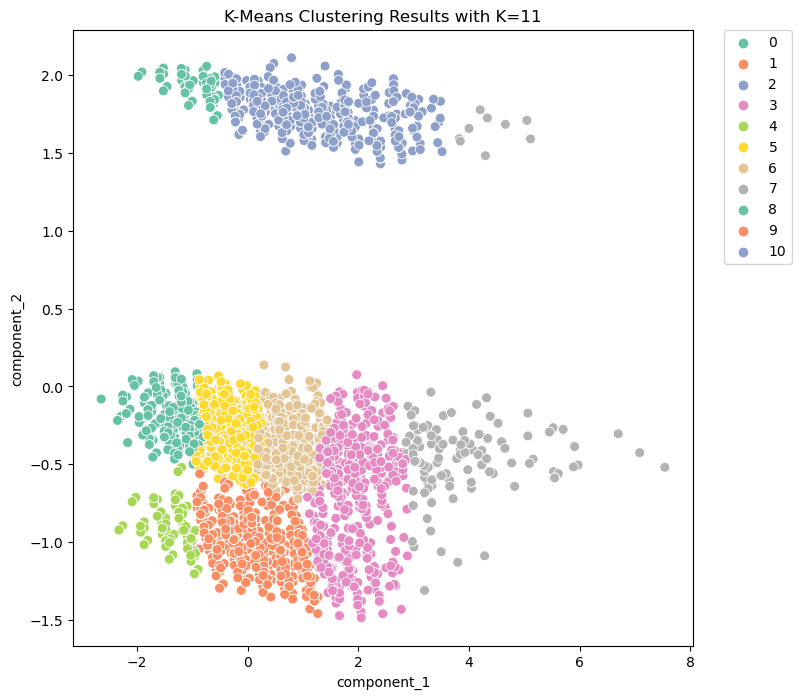

In [86]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(X_scaled),
    columns=["component_1", "component_2"]
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_

plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    data=pcadf,
    x="component_1",
    y="component_2",
    s=50,
    hue="predicted_cluster",
    palette="Set2"
)

scat.set_title(
    "K-Means Clustering Results with K=11"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [87]:
pcadf.head()

,component_1,component_2,predicted_cluster
0,-1.586818,1.980038,0
1,2.271357,1.629107,2
2,2.395777,1.468336,2
3,1.489827,1.616995,2
4,-1.586818,1.980038,0


We can also look at the distribution of employees that `left` in the 10 groups

<Axes: xlabel='predicted_cluster', ylabel='left'>

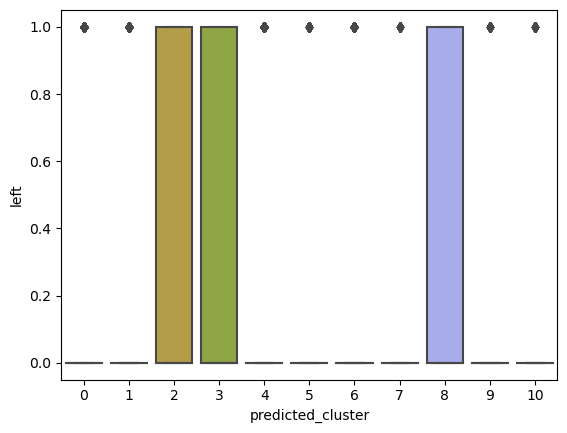

In [88]:
sns.boxplot(x=pcadf["predicted_cluster"], y=)